# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU ragas==0.2.10

In [2]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [5]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [7]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [8]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [9]:
!mkdir data

mkdir: data: File exists


In [10]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31287    0 31287    0     0  97378      0 --:--:-- --:--:-- --:--:-- 97467


In [11]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70146    0 70146    0     0   654k      0 --:--:-- --:--:-- --:--:--  658k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [12]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thomasyuill/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thomasyuill/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [13]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/thomasyuill/src/github.com/thomfoolery/llmops/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/thomasyuill/src/github.com/thomfoolery/llmops/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/thomasyuill/src/github.com/thomfoolery/llmops/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [14]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [15]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [16]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 69)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 69)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

> A: 
> - SingleHopSpecificQuerySynthesizer
>     Synthesizes a question/answer/context/truth that can be answered with a single node in the knowledge graph
>
> - MultiHopAbstractQuerySynthesizer
>     Synthesizes a question/answer/context/truth that requires multiple nodes and relationships in the knowledge graph to be answered but the connection between the question and context is more abstract
>
> - MultiHopSpecificQuerySynthesizer
>     Synthesizes a question/answer/context/truth that requires multiple nodes and relationships in the knowledge graph to be answered
>

Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What recent advancements has Google made in th...,[Gullibility is the biggest unsolved problem C...,Google is among the organizations that have pr...,single_hop_specifc_query_synthesizer
1,who andy baio and what he do with stable diffu...,[that they haven’t shared yet. Vibes Based Dev...,"Andy Baio, along with the speaker, produced th...",single_hop_specifc_query_synthesizer
2,Wht were the key advancemnts in AI by 31st Dec...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"By 31st December 2023, Large Language Models (...",single_hop_specifc_query_synthesizer
3,What insights were revealed in the leaked Goog...,[issues in a way that’s surprisingly easy to f...,The leaked Google document titled 'We Have No ...,single_hop_specifc_query_synthesizer
4,Wuz the best LLM trained in China for less tha...,[Prompt driven app generation is a commodity a...,The context mentions a question about whether ...,single_hop_specifc_query_synthesizer
5,How has the efficiency and pricing of AI model...,[<1-hop>\n\nPrompt driven app generation is a ...,The efficiency and pricing of AI models have s...,multi_hop_abstract_query_synthesizer
6,How has the efficiency and pricing of AI model...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the efficiency and pricing of AI mode...",multi_hop_abstract_query_synthesizer
7,How have advancements in prompt-driven app gen...,[<1-hop>\n\nPrompt driven app generation is a ...,Advancements in prompt-driven app generation a...,multi_hop_abstract_query_synthesizer
8,How has the issue of unlicensed training data ...,[<1-hop>\n\nthat they haven’t shared yet. Vibe...,The issue of unlicensed training data has sign...,multi_hop_specific_query_synthesizer
9,How has the development of Claude 3 and its su...,[<1-hop>\n\nneeds guidance. Those of us who un...,The development of Claude 3 and its subsequent...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [21]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wut has Meta dun in the feeld of LLMs this yeer?,[Code may be the best application The ethics o...,"In February, Meta released Llama, and in July,...",single_hop_specifc_query_synthesizer
1,What significant event related to AI ethics oc...,[Based Development As a computer scientist and...,"In September last year, the term 'prompt injec...",single_hop_specifc_query_synthesizer
2,Whaat are the key highlights from Simon Willis...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison's Weblog highlights that 2023 w...,single_hop_specifc_query_synthesizer
3,What role does Stanford Alpaca play in the dev...,[easy to follow. The rest of the document incl...,Stanford Alpaca is associated with the acceler...,single_hop_specifc_query_synthesizer
4,What are the ethical concerns associated with ...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns associated with the gulli...,multi_hop_abstract_query_synthesizer
5,Why are Large Language Models (LLMs) considere...,[<1-hop>\n\nCode may be the best application T...,Large Language Models (LLMs) are considered bl...,multi_hop_abstract_query_synthesizer
6,What are the ethical concerns related to the g...,[<1-hop>\n\nCode may be the best application T...,The ethical concerns related to the gullibilit...,multi_hop_abstract_query_synthesizer
7,How do the ethics of AI and the gullibility of...,[<1-hop>\n\nCode may be the best application T...,The ethics of AI and the gullibility of langua...,multi_hop_abstract_query_synthesizer
8,How has the development of models surpassing G...,[<1-hop>\n\nPrompt driven app generation is a ...,"In 2024, the development of models surpassing ...",multi_hop_specific_query_synthesizer
9,How does the training efficiency of DeepSeek v...,[<1-hop>\n\nday after that. DeepSeek v3 is a h...,"DeepSeek v3, a 685B parameter model, is one of...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [22]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [23]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [24]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [26]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [27]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [31]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [28]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [29]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [32]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [33]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are described as a vague term that generally refers to "AI systems that can go away and act on your behalf." There are various interpretations of what agents entail, with some seeing them as entities that perform tasks like a travel agent, while others think of them in terms of large language models (LLMs) that utilize tools to solve problems. Despite the excitement surrounding agents, few examples of them being used in production exist, and there are challenges related to their autonomy and gullibility.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [34]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [35]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
  - > A: checks the correctness of the answer, does the generated answer match the reference/ground truth
- `labeled_helpfulness_evaluator`:
  - > A: checks the correctness of the answer, but also if it helps the user with their task/goal
- `dope_or_nope_evaluator`:
  - > A: the llm simply determines itself if the answer satisfies the definition of dope/lit/cool

## LangSmith Evaluation

In [36]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'ample-edge-62' at:
https://smith.langchain.com/o/3bcc8fc9-15f2-41ae-a1d0-2d82733c1570/datasets/ab814095-c26f-49b8-b888-ae46cf262709/compare?selectedSessions=d02522eb-8af3-448a-b8b2-89d61c1ab7d5




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has Meta contributed to the advancements i...,Meta contributed to the advancements in large ...,None,Meta has significantly contributed to the adva...,1,0,1,4.087674,29509da0-b061-48e1-95e8-d939157290a9,27b53631-efba-4af2-b312-c737ada041f8
1,What are some of the challenges and advancemen...,Some challenges in LLMs discussed in Simon Wil...,None,"In Simon Willison's 2024 review, several chall...",1,0,1,5.501726,3fb9556c-6f70-4d13-bb65-e3bf2b7edcdb,15ab6e9b-c723-49eb-965b-028d27d72daf
2,How did the advancements in GPT-4o and the eme...,I don't know.,None,"In 2024, the advancements in GPT-4o and the em...",0,0,0,2.547084,20a60b9f-fbc1-400e-9303-5caf99cd32ec,d945c824-9d17-465d-a359-122e9d6dbc81
3,How has the development of large language mode...,The development of large language models (LLMs...,None,The development of large language models such ...,1,1,1,7.133917,b710696f-6dd0-4155-882c-b25daa5aacc6,b4e31ae5-5453-4c5c-bf64-4ae4bce25cd0
4,"How do the ethical considerations of AI, parti...",I don't know.,None,"The ethical considerations of AI, especially r...",0,0,0,1.925131,ca739a45-ddad-499d-a17f-8f67fe3b9d40,97c99375-03ec-497b-baf2-22eb2ac52212
5,How has OpenAI's approach to AI ethics and leg...,I don't know.,None,OpenAI has played a significant role in the de...,0,0,0,1.887500,23470146-3b11-4586-9c1e-7c6d1a934388,653be400-59f7-4d87-8f53-ae2898d03d14
6,How have the ethics of AI and the environmenta...,The context indicates that the ethics of AI re...,None,The ethics of AI and the environmental impact ...,1,0,0,2.845053,e4b68c29-4158-4d89-82ee-1334443cbbb4,be9f7acf-35ce-4f6b-9827-2a7d350f7398
7,How do the black box nature of AI and the ethi...,I don't know.,None,The development and application of Large Langu...,0,0,0,1.427569,f953df69-60b2-47bf-817c-f1cc836a3329,6b159053-be0c-41e7-9a17-bf1b487a8381
8,Wht is the signifcance of Stanford Alpaca in t...,The significance of Stanford Alpaca in the con...,None,Stanford Alpaca is mentioned in the context of...,1,1,0,4.135597,534c75b8-dcf3-4e30-aa13-3bd62275579b,43a4efdc-9272-411e-bc57-2b4abae8cdd8
9,Wht are the main chllenges associted with LLMs...,The main challenges associated with LLMs in 20...,None,Gullibility is the biggest unsolved problem as...,1,0,0,7.556519,afd7fa55-267b-4ac3-8c19-f709f16536e5,55ce83bb-fff6-4862-8e26-94b69075182c


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [37]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [38]:
rag_documents = docs

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

> A: Larger chunks can contain more context to create a quality answer
>    If chunks are too large it can confuse the model or provide unnecessary info, it's also harder to cite sources of 
>    the answer if the chunks are too large.

In [40]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

> A: Higher dimensional embedding models will find higher accuracy semantic matches, but are generally slower and more costly.
>    Lower dimensional embedding models will be less accurate in finding semantic matches but are generally faster and cheaper.
>    Embedding models primarily impact the quality, efficiency, and cost of the retrieval process.

In [41]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [42]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [43]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [44]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

"Agents are these super vague AI systems that are supposed to act on your behalf—kind of like your travel agent but way cooler. People have different ideas about what agents actually are, ranging from LLMs using tools to solve problems to something more autonomous. But here's the kicker: despite all the buzz and prototypes, they haven't really rolled out in production yet, partly due to issues like gullibility. So, still a lot of talk, but not much action, you feel me?"

Finally, we can evaluate the new chain on the same test set!

In [45]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'fixed-sleep-48' at:
https://smith.langchain.com/o/3bcc8fc9-15f2-41ae-a1d0-2d82733c1570/datasets/ab814095-c26f-49b8-b888-ae46cf262709/compare?selectedSessions=1fd0bcfc-9304-442b-9e2d-3c3bc34f50a1




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How has Meta contributed to the advancements i...,Meta has been a game-changer in the realm of l...,None,Meta has significantly contributed to the adva...,1,1,1,6.381211,29509da0-b061-48e1-95e8-d939157290a9,3e475d45-54b4-48c9-b579-027e58927bb3
1,What are some of the challenges and advancemen...,"Alright, check it out! In Simon Willison's 202...",None,"In Simon Willison's 2024 review, several chall...",1,0,1,4.819962,3fb9556c-6f70-4d13-bb65-e3bf2b7edcdb,62b322b6-bae1-4bba-8d66-82df706725dd
2,How did the advancements in GPT-4o and the eme...,I don't know.,None,"In 2024, the advancements in GPT-4o and the em...",0,0,0,2.084450,20a60b9f-fbc1-400e-9303-5caf99cd32ec,84e4cc14-377d-42a4-9f67-7730cbbd07ec
3,How has the development of large language mode...,"Alright, let’s break it down in style! \n\nThe...",None,The development of large language models such ...,1,0,1,6.314733,b710696f-6dd0-4155-882c-b25daa5aacc6,8c38e390-f28f-4802-8a3f-bed842562146
4,"How do the ethical considerations of AI, parti...","Yo, that's a deep question! So, let's break it...",None,"The ethical considerations of AI, especially r...",1,0,1,8.722128,ca739a45-ddad-499d-a17f-8f67fe3b9d40,c134cd19-19c1-45f5-b2e7-03a2a2c13bb3
5,How has OpenAI's approach to AI ethics and leg...,I don't know.,None,OpenAI has played a significant role in the de...,0,0,0,1.714371,23470146-3b11-4586-9c1e-7c6d1a934388,93394b61-c240-4894-a7cb-4a00f6930ba4
6,How have the ethics of AI and the environmenta...,"Bro, the ethics of AI have turned into a real ...",None,The ethics of AI and the environmental impact ...,1,0,1,7.535269,e4b68c29-4158-4d89-82ee-1334443cbbb4,dac5d3b9-3fd5-4f3b-9db6-cfbea4a7cbae
7,How do the black box nature of AI and the ethi...,I don't know.,None,The development and application of Large Langu...,0,0,0,2.516812,f953df69-60b2-47bf-817c-f1cc836a3329,6d5cbafb-1a6c-44c5-9024-a4b42e1ed879
8,Wht is the signifcance of Stanford Alpaca in t...,I don't know.,None,Stanford Alpaca is mentioned in the context of...,0,0,0,2.165853,534c75b8-dcf3-4e30-aa13-3bd62275579b,a6632296-4841-4035-8001-e0d45e0e0361
9,Wht are the main chllenges associted with LLMs...,I don't know.,None,Gullibility is the biggest unsolved problem as...,0,0,0,1.843755,afd7fa55-267b-4ac3-8c19-f709f16536e5,1d6c7a06-0450-4fad-b6b5-c1269c97181a


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

> A: Below is the screen shot of the evaluation of the two chains. The new chain has lower correctness and helpfulness scores, but a higher dopeness score. This is because the new chain has a larger chunk size and a better embedding model which allows it to provide more context and better semantic matches. This results in a higher quality answer which is reflected in the evaluation metrics.
>
> On the topic of helpfulness it seems that the generated response often lacks critical details that are provided in the reference answer. This is likely because the chunks are too big and the model is unable to extract the necessary information from the context. 
>
> This is also reflected in the correctness score which is lower than the original chain. The model is often responding with "I don't know" which is an instant fail. This is likely due to the model not being able to find the necessary information in the context to generate a response. This could be because the embedding model is too complex and is not able to find a suitable semantic match in the context.
>
> The dopeness score is higher in the new chain because the model simply because the prompt augmentation specifically instructs the LLM to generate a response that is considered "dope" by the LLM. Sadly it only beat out the initial chain by 2 points (5/3).

![State of AI across the years eval.png](<attachment:State of AI across the years eval.png>)
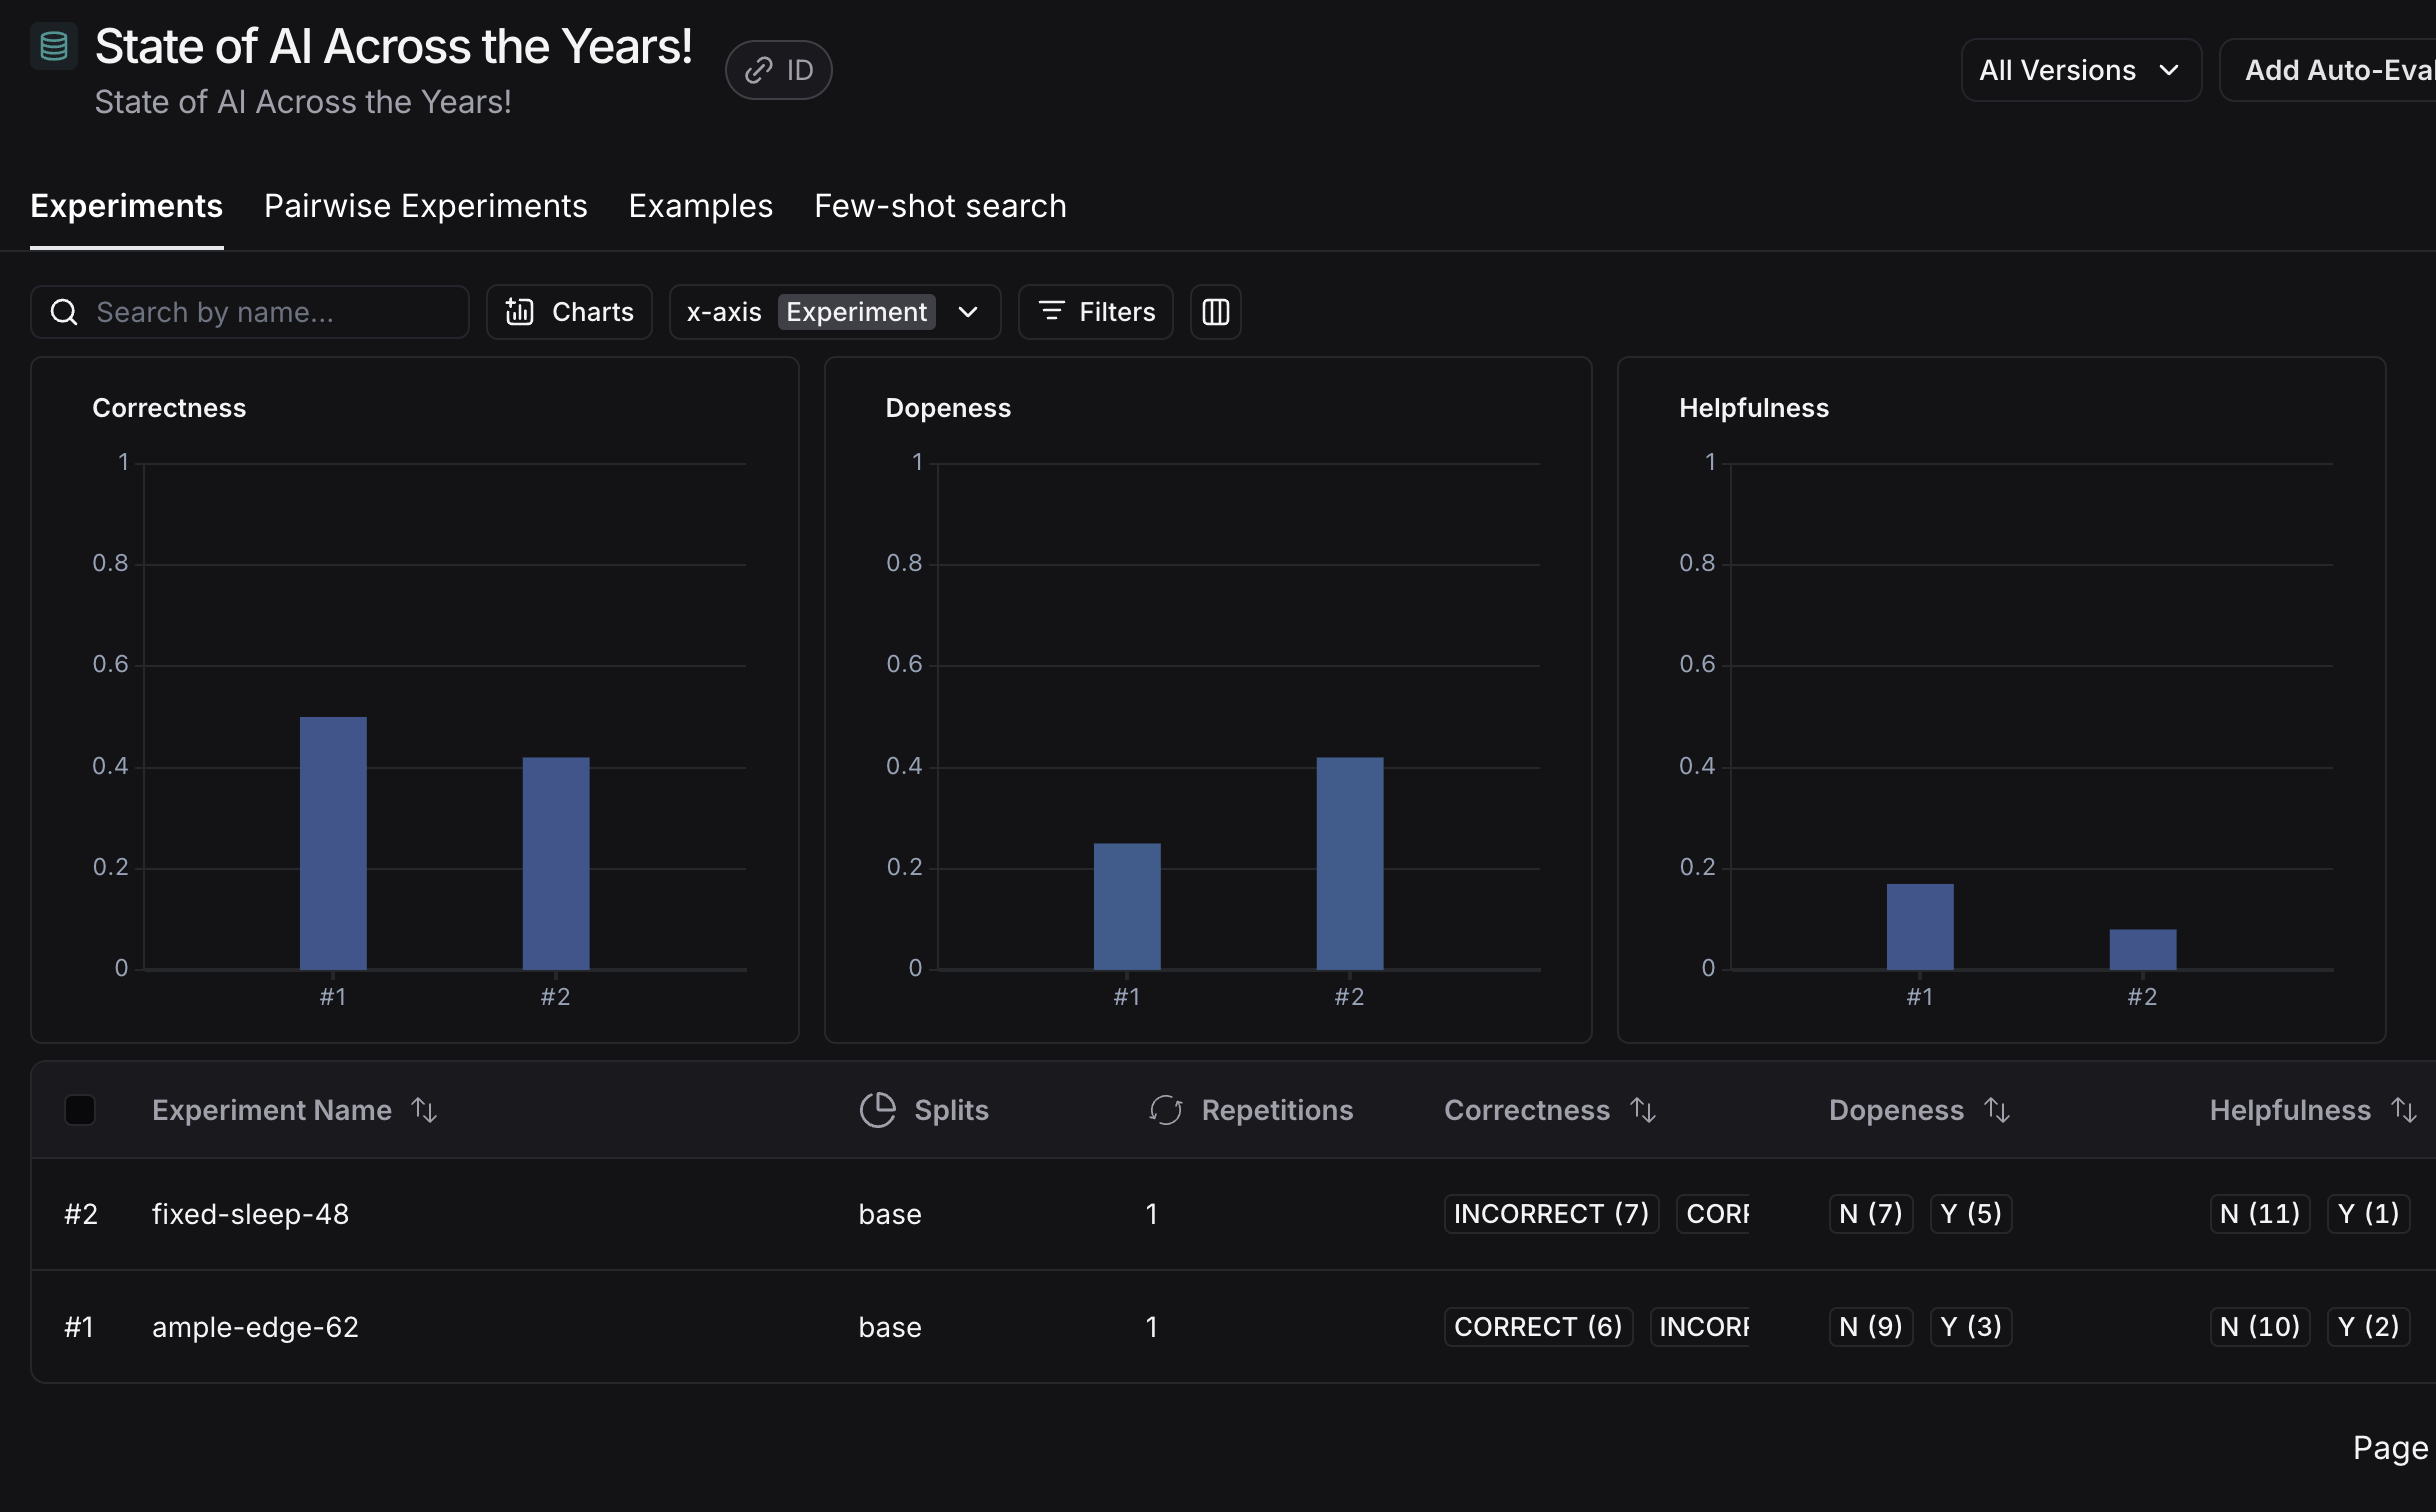

"